In [2]:
# --- CÉLULA 1: CONFIGURAÇÃO E CARREGAMENTO DE DADOS ---

# Carregar bibliotecas essenciais
# 'glmnet' para Regularização, 'readr' para carregar dados, 'caret' para particionamento
library(readr)
library(glmnet)
library(caret) 
library(Matrix) # Necessário para manipulação de matrizes do glmnet

# 1. Carregar o dataset insurance.csv
# O arquivo deve estar no mesmo diretório do seu Notebook ou use o caminho completo.
insurance_data <- read_csv("insurance.csv")

# 2. Inspecionar a estrutura
cat("Dimensões do Dataset:", dim(insurance_data), "\n")
print(head(insurance_data))

Carregando pacotes exigidos: Matrix

Loaded glmnet 4.1-10

Carregando pacotes exigidos: ggplot2

Carregando pacotes exigidos: lattice

Rows: 1338 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Dimensões do Dataset: 1338 7 
# A tibble: 6 × 7
    age sex      bmi children smoker region    charges
  <dbl> <chr>  <dbl>    <dbl> <chr>  <chr>       <dbl>
1    19 female  27.9        0 yes    southwest  16885.
2    18 male    33.8        1 no     southeast   1726.
3    28 male    33          3 no     southeast   4449.
4    33 male    22.7        0 no     northwest  21984.
5    32 male    28.9        0 no     northwest   3867.
6    31 female  25.7        0 no     southeast   3757.


In [3]:
# --- CÉLULA 2: PRÉ-PROCESSAMENTO E PARTICIONAMENTO ---

# 1. Criação das Variáveis Dummy (Feature Matrix X)
# model.matrix() converte categóricas para dummies e padroniza a matriz X.
# O termo 'charges ~ .' diz para usar 'charges' como a variável dependente 
# e todas as outras (.) como preditoras. O '[, -1]' remove a coluna de Intercepto.
X_matrix <- model.matrix(charges ~ ., data = insurance_data)[, -1]

# 2. Separar o Label (Y)
Y_vector <- insurance_data$charges

# 3. Divisão Treino/Teste (70% Treino, 30% Teste)
set.seed(42) 
# createDataPartition garante que a proporção da variável resposta (charges) seja mantida.
train_index <- createDataPartition(Y_vector, p = 0.7, list = FALSE) 

X_train <- X_matrix[train_index, ]
Y_train <- Y_vector[train_index]

X_test <- X_matrix[-train_index, ]
Y_test <- Y_vector[-train_index]

cat("Dimensões da Matriz X de Treino:", dim(X_train), "\n")
cat("Variáveis Preditoras criadas (Colunas de X_train):\n")
print(colnames(X_train))

Dimensões da Matriz X de Treino: 938 8 
Variáveis Preditoras criadas (Colunas de X_train):
[1] "age"             "sexmale"         "bmi"             "children"       
[5] "smokeryes"       "regionnorthwest" "regionsoutheast" "regionsouthwest"


Lambda Ótimo (Lasso) escolhido pela CV: 57.46561 

Coeficientes do Modelo Lasso no Lambda Ótimo (Variáveis Zeradas são menos importantes):
9 x 1 sparse Matrix of class "dgCMatrix"
                 s=57.46561
(Intercept)     -11440.6780
age                255.1052
sexmale           -265.0904
bmi                319.6924
children           351.5604
smokeryes        23800.9871
regionnorthwest      .     
regionsoutheast   -572.2277
regionsouthwest   -343.2564


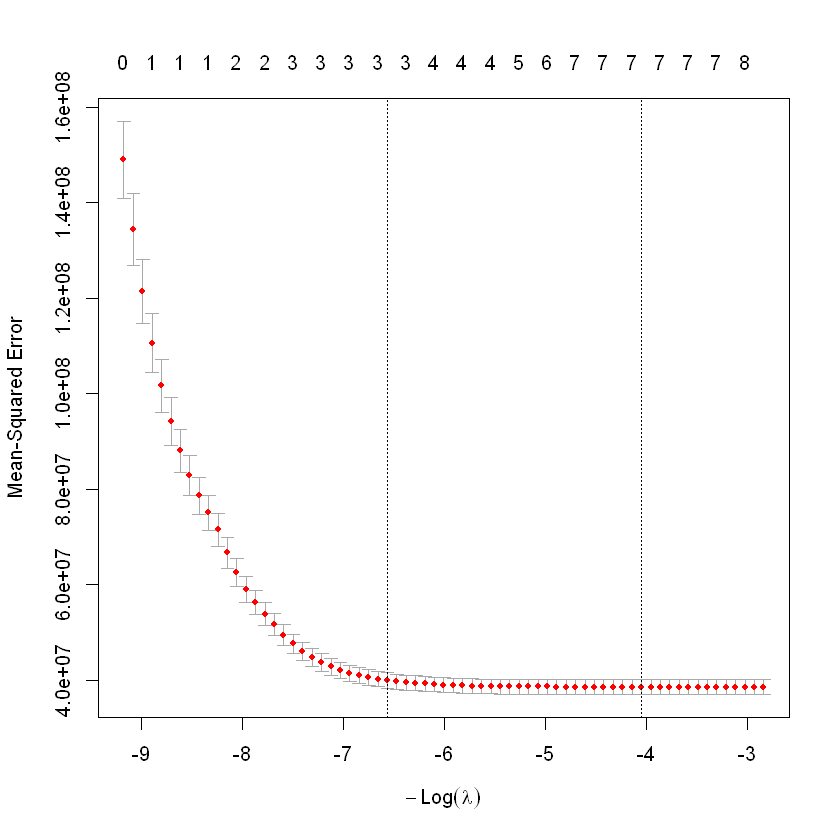

In [5]:
# --- CÉLULA 3: OTIMIZAÇÃO LASSO (ALPHA = 1) ---

# 1. Validação Cruzada (CV) para Regressão Lasso
cv_lasso <- cv.glmnet(
    x = X_train,
    y = Y_train,
    alpha = 1, # Define a penalidade L1 (Lasso)
    nfolds = 10,
    type.measure = "mse", # Minimizar o Erro Quadrático Médio
    standardize = TRUE 
)

# 2. Visualizar o erro médio (MSE) vs. Lambda 


# Você verá o gráfico do CV: a curva do MSE (ou RMSE) em função do log(lambda)
plot(cv_lasso)

# 3. Extrair o Lambda Ótimo (o que deu o menor erro)
lambda_lasso_min <- cv_lasso$lambda.min
cat("Lambda Ótimo (Lasso) escolhido pela CV:", lambda_lasso_min, "\n")

# 4. Inspecionar os Coeficientes do Modelo Final Lasso
cat("\nCoeficientes do Modelo Lasso no Lambda Ótimo (Variáveis Zeradas são menos importantes):\n")
# O 's = lambda_lasso_min' especifica o lambda a ser usado
lasso_coef <- coef(cv_lasso, s = lambda_lasso_min)
print(lasso_coef)

Lambda Ótimo (Ridge) escolhido pela CV: 958.5842 

Coeficientes do Modelo Ridge no Lambda Ótimo (Nenhum deve ser zero):
9 x 1 sparse Matrix of class "dgCMatrix"
                 s=958.5842
(Intercept)     -10146.2084
age                239.9423
sexmale           -283.8863
bmi                310.0551
children           398.1981
smokeryes        22185.1469
regionnorthwest   -151.3277
regionsoutheast   -672.5343
regionsouthwest   -530.3151


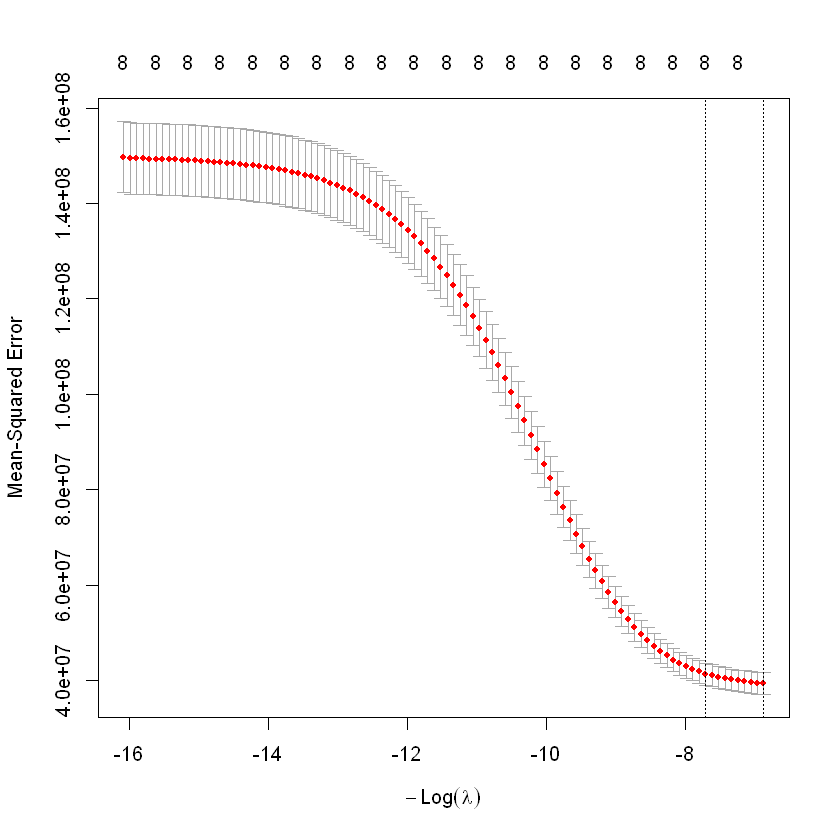

In [6]:
# --- CÉLULA 4: OTIMIZAÇÃO RIDGE (ALPHA = 0) ---

# 1. Validação Cruzada (CV) para Regressão Ridge
cv_ridge <- cv.glmnet(
    x = X_train,
    y = Y_train,
    alpha = 0, # Define a penalidade L2 (Ridge)
    nfolds = 10,
    type.measure = "mse",
    standardize = TRUE
)

# 2. Visualizar o erro médio (MSE) vs. Lambda 

plot(cv_ridge)

# 3. Extrair o Lambda Ótimo
lambda_ridge_min <- cv_ridge$lambda.min
cat("Lambda Ótimo (Ridge) escolhido pela CV:", lambda_ridge_min, "\n")

# 4. Inspecionar os Coeficientes do Modelo Final Ridge
cat("\nCoeficientes do Modelo Ridge no Lambda Ótimo (Nenhum deve ser zero):\n")
ridge_coef <- coef(cv_ridge, s = lambda_ridge_min)
print(ridge_coef)

In [7]:
# --- CÉLULA 5: AVALIAÇÃO FINAL NO SET DE TESTE ---

# 1. Fazer previsões no set de teste
predictions_lasso <- predict(cv_lasso, s = lambda_lasso_min, newx = X_test)
predictions_ridge <- predict(cv_ridge, s = lambda_ridge_min, newx = X_test)

# 2. Calcular o RMSE (Root Mean Squared Error) para Lasso
# O RMSE é a raiz quadrada do MSE
rmse_lasso <- sqrt(mean((Y_test - predictions_lasso)^2))

# 3. Calcular o RMSE para Ridge
rmse_ridge <- sqrt(mean((Y_test - predictions_ridge)^2))

cat("--- Desempenho no Set de Teste ---\n")
cat("RMSE Lasso (L1):", round(rmse_lasso, 2), "R$\n")
cat("RMSE Ridge (L2):", round(rmse_ridge, 2), "R$\n")

# Comparação: O modelo com o menor RMSE é o de melhor desempenho.

--- Desempenho no Set de Teste ---
RMSE Lasso (L1): 5763.2 R$
RMSE Ridge (L2): 5792.96 R$
